<a href="https://colab.research.google.com/github/edgleuma-abreu/IGTI/blob/main/Projeto_Aplicado_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTAÇÃO DE BIBLIOTECAS**

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 40.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats

import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

import math
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error


In [3]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

#from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings("ignore")

In [4]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [5]:
#Ler dados
df =pd.read_csv("dataset_pa_v2.csv", delimiter=";")

df_mem = df[['datahora', 'mem_usage']]
df_cpu = df[['datahora', 'cpu_usage']]

In [6]:
df.head()

#df_mem.head()
#df_cpu.head()

,datahora,mem_usage,cpu_usage
0,02/10/22 14:00,223,6.37
1,02/10/22 15:00,224,6.07
2,02/10/22 16:00,224,6.31
3,02/10/22 17:00,224,6.18
4,02/10/22 18:00,224,6.28


In [7]:
#Tamanho do dataset
df.shape

(337, 3)

In [8]:
#Verificar valores nulos
df.isna().sum()

datahora     0
mem_usage    0
cpu_usage    0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datahora   337 non-null    object 
 1   mem_usage  337 non-null    int64  
 2   cpu_usage  337 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.0+ KB


In [10]:
#df.index = df[["datahora"]].apply(pd.to_datetime, format="%d/%m/%y %H:%M")
#df_mem.index = df_mem[["datahora"]].apply(pd.to_datetime, format="%d/%m/%y %H:%M")
df_cpu['datahora'] = df_cpu[["datahora"]].apply(pd.to_datetime, format="%d/%m/%y %H:%M")


In [11]:
df_cpu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datahora   337 non-null    datetime64[ns]
 1   cpu_usage  337 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.4 KB


##Verificar se as séries são estacionárias

In [12]:
adfuller_test(df_mem['mem_usage'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8668
 No. Lags Chosen       = 5
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.3478. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [13]:
adfuller_test(df_cpu['cpu_usage'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7565
 No. Lags Chosen       = 4
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0648. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


**Ambas as séries são NÃO ESTACIONÁRIAS**

##Transformar em não estacionárias

In [14]:
#Memória
first_diff_mem = df_mem['mem_usage'].diff() # Differencing the first order
first_diff_mem.dropna(inplace = True) # Removing problems

adfuller_test(first_diff_mem)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4789
 No. Lags Chosen       = 4
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [15]:
#CPU
first_diff_cpu = df_cpu['cpu_usage'].diff() # Differencing the first order
first_diff_cpu.dropna(inplace = True) # Removing problems

adfuller_test(first_diff_cpu)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.1391
 No. Lags Chosen       = 1
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [16]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

print('numpy version: %r' % np.__version__)
print('pmdarima version: %r' % pm.__version__)


# Load/split your data
y = first_diff_cpu
train, test = train_test_split(y, train_size=250)

# Fit your model
model = pm.auto_arima(train, start_p=1, start_q=1, max_p=4, max_q=4, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

model.fit(train)
forecast = model.predict(test.shape[0])


numpy version: '1.21.6'
pmdarima version: '2.0.1'
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=867.382, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=671.858, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=734.529, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=645.707, Time=0.58 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=773.957, Time=0.35 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=598.267, Time=0.67 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=621.560, Time=0.27 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=565.456, Time=0.74 sec
 ARIMA(

In [17]:
model.aic()

550.1488696954746

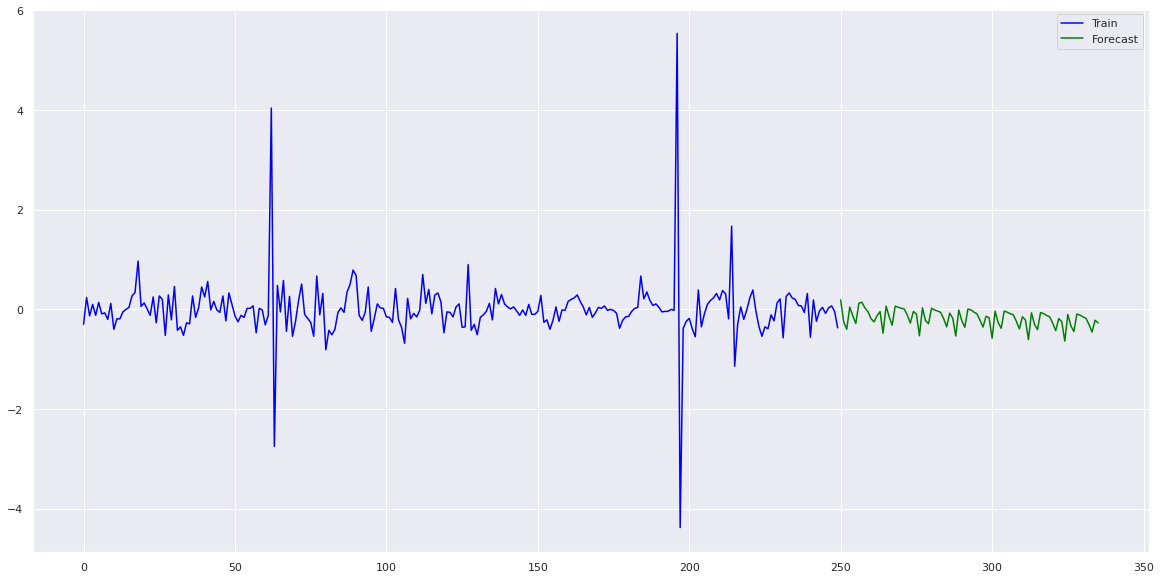

In [18]:
# Visualize the forecasts (blue=train, green=forecasts)
sns.set(rc={'figure.figsize':(20,10)})
x = np.arange(y.shape[0])
plt.plot(x[:250], train, c='blue')
plt.plot(x[250:], forecast, c='green')
plt.legend (labels=['Train', 'Forecast'])
plt.show()

In [19]:
print ("MAE: ", metrics.mean_absolute_error(test, forecast)) 
print ("MSE: ",metrics.mean_squared_error(test, forecast))
print ("RMSE: ",math.sqrt(metrics.mean_squared_error(test, forecast)))
print("MAPE:", metrics.mean_absolute_percentage_error(test, forecast))


MAE:  0.7752268269524373
MSE:  3.9321181696450638
RMSE:  1.982956925816863
MAPE: 1753277744293.4963


#Prophet

In [20]:
!pip install Prophet
from prophet import Prophet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
df_cpu.columns=['ds','y']

treino = df_cpu[:250]
teste = df_cpu[250:]





In [22]:
teste

,ds,y
250,2022-10-13 00:00:00,6.67
251,2022-10-13 01:00:00,6.37
252,2022-10-13 02:00:00,5.95
253,2022-10-13 03:00:00,5.79
254,2022-10-13 04:00:00,5.75
...,...,...
332,2022-10-16 10:00:00,5.79
333,2022-10-16 11:00:00,5.85
334,2022-10-16 12:00:00,5.92
335,2022-10-16 13:00:00,6.11


In [23]:
m = Prophet() 
m.fit(treino) #fit the model with your dataframe

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujrmxx9a/7xkbjr0x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujrmxx9a/zz61qii2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3587', 'data', 'file=/tmp/tmpujrmxx9a/7xkbjr0x.json', 'init=/tmp/tmpujrmxx9a/zz61qii2.json', 'output', 'file=/tmp/tmpujrmxx9a/prophet_modelxpi8onkh/prophet_model-20221024002622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:26:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:26:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [123]:
# predict for five months in the furure and MS - month start is the frequency
modelo = m.make_future_dataframe(periods = 96, freq='H')  #equivalente


In [103]:
previsao = m.predict(modelo)

In [104]:
previsao.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
341,2022-10-16 19:00:00,8.582587,8.108292,9.913901,8.047033,9.125448,0.402616,0.402616,0.402616,0.402616,0.402616,0.402616,0.0,0.0,0.0,8.985202
342,2022-10-16 20:00:00,8.595104,8.057125,10.022966,8.046997,9.147620,0.418373,0.418373,0.418373,0.418373,0.418373,0.418373,0.0,0.0,0.0,9.013477
343,2022-10-16 21:00:00,8.607622,8.021980,9.837678,8.052120,9.171189,0.370925,0.370925,0.370925,0.370925,0.370925,0.370925,0.0,0.0,0.0,8.978548
344,2022-10-16 22:00:00,8.620140,7.881963,9.846533,8.057694,9.196344,0.227650,0.227650,0.227650,0.227650,0.227650,0.227650,0.0,0.0,0.0,8.847790
345,2022-10-16 23:00:00,8.632658,7.701925,9.555092,8.060059,9.217419,-0.009979,-0.009979,-0.009979,-0.009979,-0.009979,-0.009979,0.0,0.0,0.0,8.622679


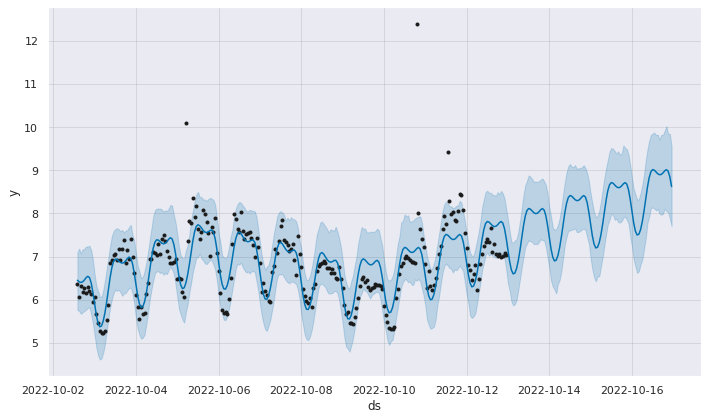

In [ ]:
m.plot(previsao)

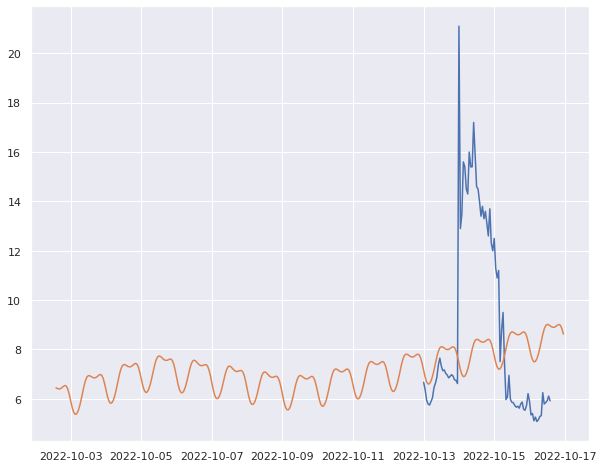

In [124]:
sns.set(rc={'figure.figsize':(10,8)})
plt.plot(teste['ds'], teste['y'])
plt.plot(previsao['ds'], previsao['yhat'])

In [107]:
previsao.shape

(346, 16)

In [61]:
previsao.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
413,2022-10-19 19:00:00,9.483873,8.334135,11.498456,8.025637,10.948748,0.402616,0.402616,0.402616,0.402616,0.402616,0.402616,0.0,0.0,0.0,9.886489
414,2022-10-19 20:00:00,9.496391,8.223984,11.539364,8.025742,10.970004,0.418373,0.418373,0.418373,0.418373,0.418373,0.418373,0.0,0.0,0.0,9.914764
415,2022-10-19 21:00:00,9.508909,8.230284,11.450225,8.017659,10.996491,0.370925,0.370925,0.370925,0.370925,0.370925,0.370925,0.0,0.0,0.0,9.879834
416,2022-10-19 22:00:00,9.521427,8.068367,11.354031,8.002737,11.028619,0.227650,0.227650,0.227650,0.227650,0.227650,0.227650,0.0,0.0,0.0,9.749077
417,2022-10-19 23:00:00,9.533945,7.865432,11.144663,8.004495,11.060366,-0.009979,-0.009979,-0.009979,-0.009979,-0.009979,-0.009979,0.0,0.0,0.0,9.523965


In [115]:

# Python
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='1 hour', period='24 hours', horizon = '168 hours')

INFO:prophet:Making 4 forecasts with cutoffs between 2022-10-02 23:00:00 and 2022-10-05 23:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujrmxx9a/b0fjevez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujrmxx9a/ftgnv3cz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7564', 'data', 'file=/tmp/tmpujrmxx9a/b0fjevez.json', 'init=/tmp/tmpujrmxx9a/ftgnv3cz.json', 'output', 'file=/tmp/tmpujrmxx9a/prophet_model3iu07hli/prophet_model-20221024012726.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:27:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:27:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujrmxx9a/zt_g6lz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujrmxx9a/klcqjrba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:runni

In [117]:
df_cv.tail()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
667,2022-10-12 19:00:00,11.363894,10.767843,11.994808,7.06,2022-10-05 23:00:00
668,2022-10-12 20:00:00,11.368855,10.769240,11.944516,6.98,2022-10-05 23:00:00
669,2022-10-12 21:00:00,11.453594,10.859249,12.030310,7.01,2022-10-05 23:00:00
670,2022-10-12 22:00:00,11.461013,10.793864,12.028098,7.08,2022-10-05 23:00:00
671,2022-10-12 23:00:00,11.274566,10.671983,11.897380,7.04,2022-10-05 23:00:00


In [121]:
cutoffs = pd.to_datetime(['2022-10-03 00:00:00', '2022-10-4 00:00:00', '2022-10-05 23:00:00'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='168 hours')

  0%|          | 0/3 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujrmxx9a/73qkxjw5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujrmxx9a/z9ttgi6_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75198', 'data', 'file=/tmp/tmpujrmxx9a/73qkxjw5.json', 'init=/tmp/tmpujrmxx9a/z9ttgi6_.json', 'output', 'file=/tmp/tmpujrmxx9a/prophet_model0mcndeur/prophet_model-20221024020200.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:02:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:02:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujrmxx9a/u_sqr437.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujrmxx9a/m_dkdugu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:runn

In [122]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(150)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 17:00:00,103.137699,10.155673,4.327302,0.681674,0.112270,0.359838,0.126866
1,0 days 18:00:00,103.438606,10.170477,4.385314,0.688162,0.116859,0.363041,0.104478
2,0 days 19:00:00,103.577455,10.177301,4.403597,0.687984,0.116859,0.354548,0.104478
3,0 days 20:00:00,103.142196,10.155895,4.362336,0.676266,0.112270,0.330320,0.119403
4,0 days 21:00:00,102.403218,10.119448,4.317972,0.662867,0.116859,0.308911,0.119403
...,...,...,...,...,...,...,...,...
145,6 days 18:00:00,649.901827,25.493172,14.486594,2.376628,0.833394,0.673718,0.250000
146,6 days 19:00:00,660.763633,25.705323,14.653953,2.393858,0.720688,0.674790,0.250000
147,6 days 20:00:00,673.928163,25.960126,14.788917,2.403390,0.720688,0.667861,0.250000
148,6 days 21:00:00,688.886955,26.246656,15.021752,2.426269,0.681140,0.668402,0.250000


In [108]:
# print("MAE: ", metrics.mean_absolute_error(teste, previsao)) 
# print("MSE: ",metrics.mean_squared_error(teste, previsao))
# print("RMSE: ",math.sqrt(metrics.mean_squared_error(teste, previsao)))
# print("MAPE:", metrics.mean_absolute_percentage_error(teste, previsao))

ValueError: ignored

In [72]:
#metricas = previsao

In [73]:
#metricas = pd.DataFrame({"datahora" : metricas[-168:]['ds'], "Pred" : metricas[-168:]["yhat"]})

In [74]:
#metricas = metricas.set_index("datahora")

In [75]:
#metricas.index.freq = "H"

In [76]:
#metricas

,Pred
datahora,
2022-10-13 00:00:00,7.143587
2022-10-13 01:00:00,6.879422
2022-10-13 02:00:00,6.687489
2022-10-13 03:00:00,6.598609
2022-10-13 04:00:00,6.614445
...,...
2022-10-19 19:00:00,9.886489
2022-10-19 20:00:00,9.914764
2022-10-19 21:00:00,9.879834


In [77]:
#test_data["Prophet_Predictions"] = metricas['Pred'].values

NameError: ignored

In [ ]:
#metricas['Pred'].values

ValueError: ignored

ValueError: ignored

In [ ]:

plot_components_plotly(m, previsao)

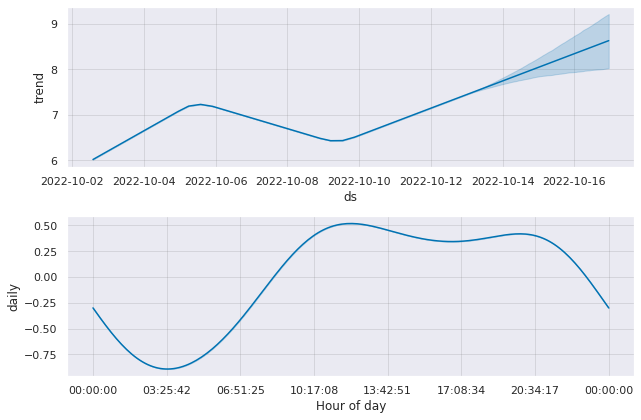

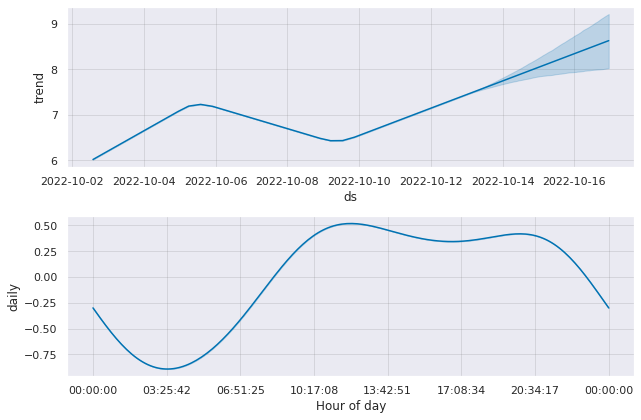

In [95]:
m.plot_components(previsao)

In [98]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, previsao)

In [100]:
# from prophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cpu)
# df_p.head()

KeyError: ignored

**PREPARAÇÃO DOS DADOS**

##Fazer resample do dataset_pa e ver se fica bom ou pior :(

##Entender o decompose

In [ ]:
#Ler dados
df_teste =pd.read_csv("dataset_estudo.csv", delimiter=";")

In [ ]:
df_teste.shape

df_teste.head()

,datetime,cpu,mem,networkio
0,2022-07-25T03:48:30-03:00,0.000840,52142080,22.937.234.682.757.800
1,2022-07-25T03:48:45-03:00,0.000772,52432896,16.626.793.578.206.900
2,2022-07-25T03:49:00-03:00,0.000854,52162560,1.761.552.926.755.880
3,2022-07-25T03:49:15-03:00,0.000854,52162560,19.774.713.787.037.200
4,2022-07-25T03:49:30-03:00,0.000854,52162560,19.774.713.787.037.200


In [ ]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57598 entries, 0 to 57597
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   57598 non-null  object 
 1   cpu        57598 non-null  float64
 2   mem        57598 non-null  object 
 3   networkio  57598 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.8+ MB


In [ ]:
df_teste.drop(['networkio'],axis=1)

,datetime,cpu,mem
0,2022-07-25 03:48:30-03:00,0.000840,52142080
1,2022-07-25 03:48:45-03:00,0.000772,52432896
2,2022-07-25 03:49:00-03:00,0.000854,52162560
3,2022-07-25 03:49:15-03:00,0.000854,52162560
4,2022-07-25 03:49:30-03:00,0.000854,52162560
...,...,...,...
57593,2022-07-25 15:42:00-03:00,0.000885,52207616
57594,2022-07-25 15:42:15-03:00,0.000898,52207616
57595,2022-07-25 15:42:30-03:00,0.000888,52207616
57596,2022-07-25 15:42:45-03:00,0.000882,52207616


In [ ]:
df_teste["datetime"] = pd.to_datetime,(df_teste["datetime"])

#

ValueError: ignored

In [ ]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57598 entries, 0 to 57597
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype                                 
---  ------     --------------  -----                                 
 0   datetime   57598 non-null  datetime64[ns, pytz.FixedOffset(-180)]
 1   cpu        57598 non-null  float64                               
 2   mem        57598 non-null  object                                
 3   networkio  57598 non-null  object                                
dtypes: datetime64[ns, pytz.FixedOffset(-180)](1), float64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
df_teste_ajustado = df_teste.resample('H').mean()


df['date'] = pd.to_datetime(df['date'])
weekly_summary = df.story_point.resample('W', on='date').sum()

TypeError: ignored